# Data Cleaning - Airbnb Calendar Data

## Introduction

In the following notebook, I'll be cleaning up the calendar data SF_Calendar_Nov2018_Oct2019.csv

**Read in necessary libraries**

In [8]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd

import re

import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

**Settings for Notebook**

In [9]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#supress future warnings
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)

**Read in Data**

In [10]:
#Set path to get aggregated Calendar data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\SF Airbnb Raw Data - Aggregated\SF_Calendar_Nov2018_Oct2019.csv'

#Set date columns for parsing
parse_dates = ['date']

#Read in calendar data
calendar = pd.read_csv(path, sep = '\t', parse_dates=parse_dates,index_col=0, low_memory=False)

## Data Preview

In [11]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,$80.00,f,2019-04-03,187730,120.0,3.0,$80.00
1,$80.00,f,2019-04-04,187730,120.0,3.0,$80.00
2,$82.00,t,2019-04-05,187730,120.0,3.0,$82.00
3,$82.00,t,2019-04-06,187730,120.0,3.0,$82.00
4,$81.00,t,2019-04-07,187730,120.0,3.0,$81.00


In [12]:
#Print shape dtypes of calendar data
print('Calendar data shape:',calendar.shape)
print('\nCalendar data types: \n',calendar.dtypes)

Calendar data shape: (15901917, 7)

Calendar data types: 
 adjusted_price            object
available                 object
date              datetime64[ns]
listing_id                 int64
maximum_nights           float64
minimum_nights           float64
price                     object
dtype: object


Due to size of the Airbnb calendar data, we will manually explore the dataset. First we will correct some of the data types in order to get metrics about the calendar data.

## Data Cleaning

**Data Type Conversion**

In [13]:
#Remove $ and , from price and adjusted price column
cols = ['adjusted_price', 'price']
calendar[cols]=calendar[cols].replace('[,$]','', regex=True)

#Convert string to numeric
calendar[cols] =calendar[cols].swifter.apply(pd.to_numeric, errors='coerce')

#Replace 't' and 'f' in available column to True and False
calendar.available = calendar.available.swifter.apply(lambda x:  1 if x =='t' else 0)

#Correct data type for data column
calendar.date=pd.to_datetime(calendar.date)

**View calendar metrics**

In [14]:
#Describe calendar data
print(calendar.describe())
 
#Print variance within calendar data
print('\nCalendar variance: \n',calendar.var(axis=0))

       adjusted_price     available    listing_id  maximum_nights  \
count    1.244963e+07  1.590192e+07  1.590192e+07    1.244997e+07   
mean     2.283015e+02  4.513422e-01  1.837323e+07    1.397483e+04   
std      3.622993e+02  4.976268e-01  1.097891e+07    1.158453e+06   
min      0.000000e+00  0.000000e+00  9.580000e+02    1.000000e+00   
25%      1.050000e+02  0.000000e+00  8.275596e+06    2.800000e+01   
50%      1.600000e+02  0.000000e+00  2.025848e+07    1.800000e+02   
75%      2.500000e+02  1.000000e+00  2.795734e+07    1.125000e+03   
max      1.019900e+04  1.000000e+00  3.855723e+07    1.000000e+08   

       minimum_nights         price  
count    1.244997e+07  1.414632e+07  
mean     1.347311e+04  2.283821e+02  
std      1.158443e+06  5.154473e+02  
min      1.000000e+00  0.000000e+00  
25%      2.000000e+00  1.040000e+02  
50%      3.000000e+00  1.590000e+02  
75%      3.000000e+01  2.490000e+02  
max      1.000000e+08  2.207130e+05  

Calendar variance: 
 adjusted_price

**Missing Data**

In [15]:
#Capture total number of missing data per column
total = calendar.isnull().sum().sort_values(ascending=False)

#Calculate the % of missing data per column
percent = (calendar.isnull().sum()/calendar.isnull().count()).sort_values(ascending=False)

#Concatenate into a pd dataframe
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Missing Percent'])

#Format percentage  
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)

#View columns with > 10% of data missing
missing_data.loc[missing_data['Missing Percent'] > 10][:10]

,Total Missing,Missing Percent
adjusted_price,3452285,21.709867
minimum_nights,3451949,21.707754
maximum_nights,3451949,21.707754
price,1755600,11.040178


Calendar data distributions

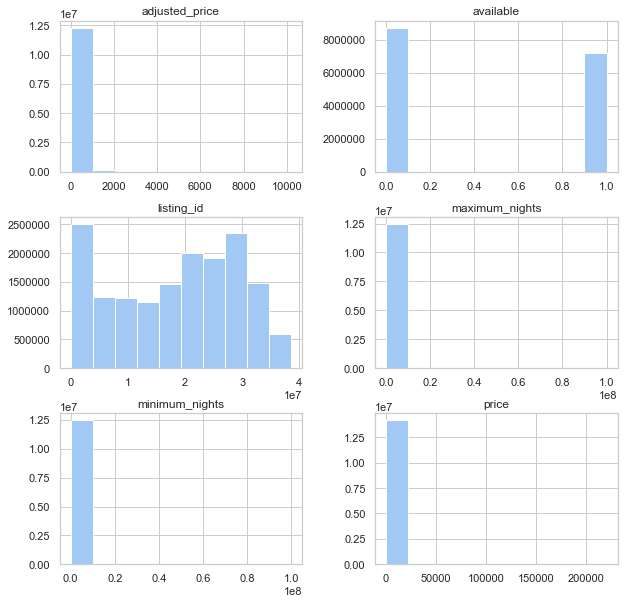

In [16]:
#Display distributions of calendar data
calendar.hist(figsize=(10,10));

#### Price Outlier Removal

**Identify and remove outliers using IQR**

In [17]:
#Calculate IQR of price
q25 = calendar['price'].quantile(0.25)
q75= calendar['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in calendar.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in calendar.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
calendar = calendar[calendar.price.isin(outliers_removed)]
print('New calendar shape: ', calendar.shape)

Percentiles: 25th=104.000, 75th=249.000 
IQR= 145.000
Number of outliers identified: 1499300
Non-outlier observations: 12647017
New calendar shape:  (12647017, 7)


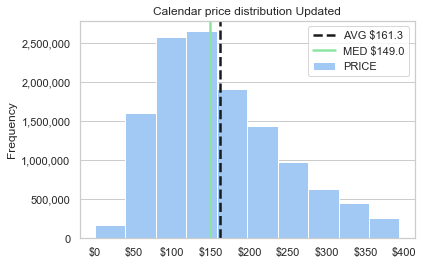

In [18]:
#Plot updated prices from calendar data
calendar.price.plot(kind = 'hist',  title = 'Calendar price distribution Updated', label = 'PRICE',
                   legend = True)

#Get plot object
ax = plt.gca()

#Capture mean and median
mean = np.mean(calendar.price)
median = np.median(calendar.price)

#Plot mean and median to histogram
ax.axvline(mean, color='k', linestyle='dashed', linewidth=2.5, label = "AVG ${:}".format(str(round(mean,2))))
ax.axvline(median, color='g', linestyle='solid', linewidth=2.5, label = "MED ${:}".format(str(round(median,2))))

#Format x-axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Format y ticks
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Show legend
plt.legend(frameon = True, loc='upper right');

# Is it necessary to also remove outliers from max and min nights?

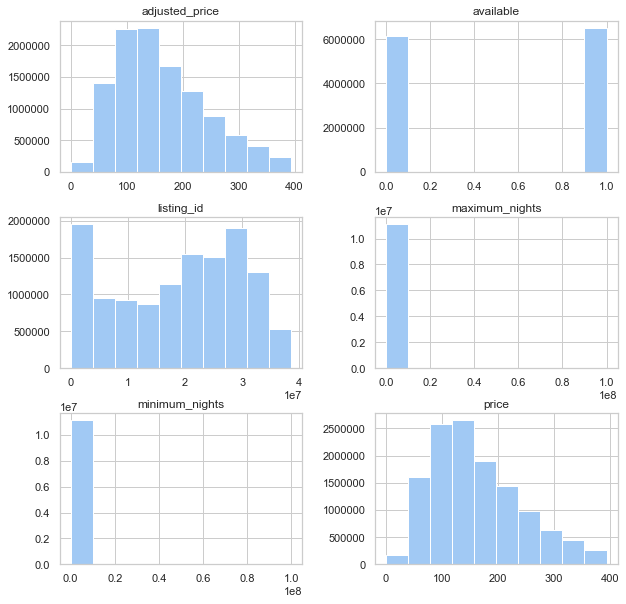

In [19]:
#Display distributions of calendar data
calendar.hist(figsize=(10,10));

In [ ]:
# #Set path to write listings
# path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate\calendar_cleaned.csv'

# #Write listings to path
# calendar.to_csv(path)